# Embedding

## Overview

In this project we will try some embedding models on text data and visualize those learned embeddings.

In [2]:
import os
import sys

DATA_PATH = "lib/data/"

## About Raw Data

Navigate to `DATA_PATH`, there is a csv file used for training. The data is originally from the [NFCorpus database](https://www.cl.uni-heidelberg.de/statnlpgroup/nfcorpus/).

In [3]:
!ls {DATA_PATH}

corpus.csv


The data provided in *corpus.csv* consists of medical articles from [PubMed](https://pubmed.ncbi.nlm.nih.gov).

In [4]:
import pandas as pd


def load_dataset(filepath):    
    """ Read the cospus.csv file """
    return pd.read_csv(filepath)


corpus_df = load_dataset(os.path.join(DATA_PATH, 'corpus.csv'))
corpus_df.head()

,ID,TEXT
0,MED-10,"Recent studies have suggested that statins, an..."
1,MED-14,BACKGROUND: Preclinical studies have shown tha...
2,MED-118,The aims of this study were to determine the c...
3,MED-301,Epilepsy or seizure disorder is one of the mos...
4,MED-306,Hit Reaction Time latencies (HRT) in the Conti...


## 1 Word2Vec

We will first perform word2vec on the given NFCorpus dataset.

### 1.1 Preprocess the text data

- Remove newline ('\n')
- Remove carriage returns ('\r')
- Remove punctuations
- Remove numbers
- Convert to lower-case
- Split each sentence into a list of words

In [5]:
import time
import numpy as np
import string
from nltk import word_tokenize

def preprocess_dataset(df):    
    ''' 
    Preprocess the text data and return a list of articles where each article is broke into a list of words. 
    '''
    corpus_processed = []
    
    df.TEXT = df.TEXT.str.replace('\n', '')  # remove newline
    df.TEXT = df.TEXT.str.replace('\r', '')  # carriage returns
    df.TEXT = df.TEXT.str.translate(str.maketrans('', '', string.punctuation)) # remove punctuations
    df.TEXT = df.TEXT.str.translate(str.maketrans('', '', string.digits)) # remove numbers
    df.TEXT = df.TEXT.str.lower()  # convert to lower case
    
    # tokenize
    for note in df.TEXT.values:
        note_tokenized = word_tokenize(note)
        corpus_processed.append(note_tokenized)

    return corpus_processed

In [6]:
corpus_processed = preprocess_dataset(corpus_df)

### 1.2 Train a word2vec model

Now that the training dataset is ready, we will be using Word2Vec from gensim.  
1. Set the word vector size to 100. 
2. Ignores all words with total frequency lower than (<) 20. 
3. use only 1 worker (workers=1) to ensure deterministic behavior
4. set the seed to the provided value RANDOM_SEED
5. Keep the other paramters as default. 
6. Train the model (Word2Vec) on the training dataset.

REFERENCE: [tutorial](https://radimrehurek.com/gensim/models/word2vec.html)

In [9]:
RANDOM_SEED = 23432098
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Dimensionality of the word vectors
VEC_SIZE = 100
# Ignores all words with total frequency lower than this
MIN_COUNT = 20

from gensim.models import Word2Vec

# Train the Word2Vec model (`w2v_model`).
w2v_model = Word2Vec(sentences=corpus_processed, vector_size=VEC_SIZE, seed=RANDOM_SEED, min_count=MIN_COUNT, workers=1)


In [10]:
print("Size of vocab: %d" % len(w2v_model.wv))

Size of vocab: 3660


### 1.3 Evaluate the model

**Find distinct word*: Given three words (e.g. 'heart', 'lung' and 'protein'), find the distinct word (e.g. 'protein').

In [16]:

def find_distinct_word(model, list_of_words):
    
    """
    Find the distinct word from the list using the trained word2vec model.
    input
      model: word2vec model
      list_of_words: a list of words, e.g. ['heart', 'lung', 'protein']
    output
      distinct_word: the distinct word
    """
    return model.wv.doesnt_match(list_of_words)


In [17]:
list_of_words = ['heart', 'lung', 'protein']
print("The distinct word among '%s' is: '%s'." % (', '.join(list_of_words), find_distinct_word(w2v_model, list_of_words)))

list_of_words = ['carbohydrate', 'sugars', 'lung']
print("The distinct word among '%s' is: '%s'." % (', '.join(list_of_words), find_distinct_word(w2v_model, list_of_words)))

The distinct word among 'heart, lung, protein' is: 'protein'.
The distinct word among 'carbohydrate, sugars, lung' is: 'lung'.


**Similar words**: Given a word (e.g. 'blood'), find the list of words similar to this word (e.g. one such word is 'pressure').

In [22]:

def similar_word(model, word):
    
    """
    Find the words similar to the given word.
    input: 
        model: word2vec model
        word: a single word, e.g. 'heart'
    output: 
        list_of_words: a list of words similar to the given word
    """

    list_of_words = [pair[0] for pair in model.wv.most_similar(word)]
    return list_of_words

In [23]:
word = 'blood'
print("The words similar to '%s' are: '%s'." % (word, ', '.join(similar_word(w2v_model, word))))

word = 'protein'
print("The words similar to '%s' are: '%s'." % (word, ', '.join(similar_word(w2v_model, word))))

The words similar to 'blood' are: 'pressure, fasting, bp, arterial, glucose, diastolic, systolic, lipids, flow, lipid'.
The words similar to 'protein' are: 'fat, saturated, fats, carbohydrate, iron, fibre, absorption, content, calcium, soy'.


## 2 t-SNE, UMAP

Next, we will perform t-SNE and UMAP on the medical representations obtained from the previous sections.

In [25]:
from gensim.models import Word2Vec

# words
W = list(w2v_model.wv.key_to_index.keys())
# embeddings
X = np.array([w2v_model.wv[w] for w in W])

# select only a subset of the words
X_subset = X[:1000]
W_subset = W[:1000]

In [26]:
import matplotlib.pyplot as plt
import random

def plot(X, Y, W):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.plot(Y[:, 0], Y[:, 1], 'o')
    ax.set_yticklabels([]) #Hide ticks
    ax.set_xticklabels([]) #Hide ticks

    for i, word in enumerate(W):
        if random.uniform(0,1) > 0.9:
            plt.annotate(word, xy=(Y[i, 0], Y[i, 1]))
    plt.show()

### 2.1 t-SNE

Perform t-SNE on `X_subset` and plot the results. 

REFERENCE: [tutorial](https://www.datacamp.com/community/tutorials/introduction-t-sne)

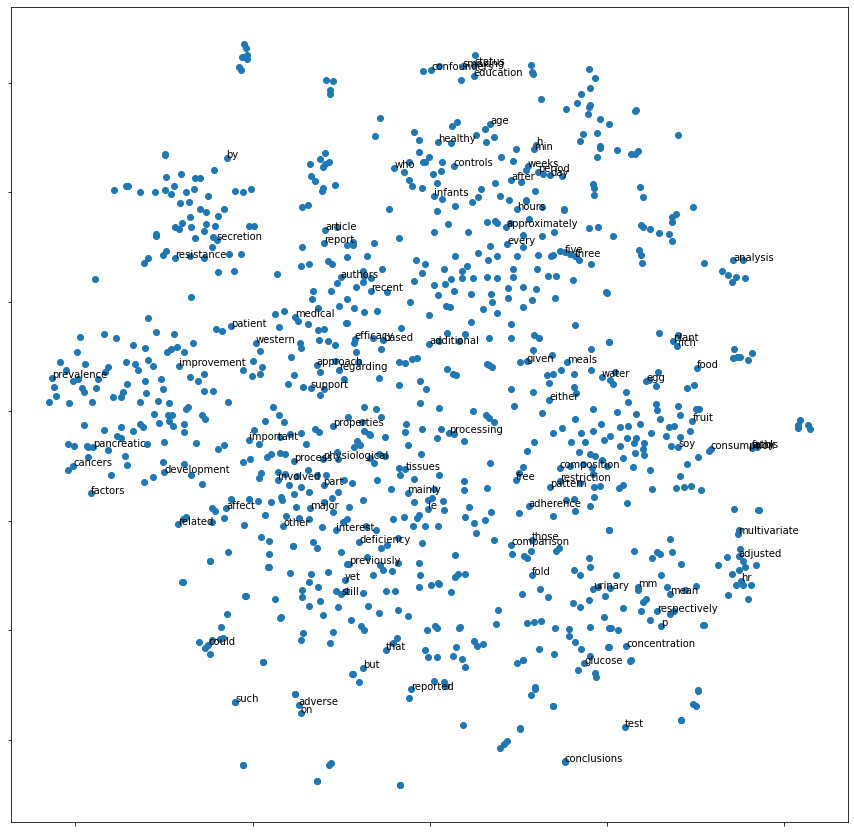

In [27]:
# t-SNE
from sklearn.manifold import TSNE
Y_subset_tsne = TSNE(random_state=RANDOM_SEED).fit_transform(X_subset)
plot(X_subset, Y_subset_tsne, W_subset)

### 2.2 UMAP

Perform UMAP on `X_subset` and plot the results. 

REFERENCE: [tutorial](https://umap-learn.readthedocs.io/en/latest/basic_usage.html#digits-data)

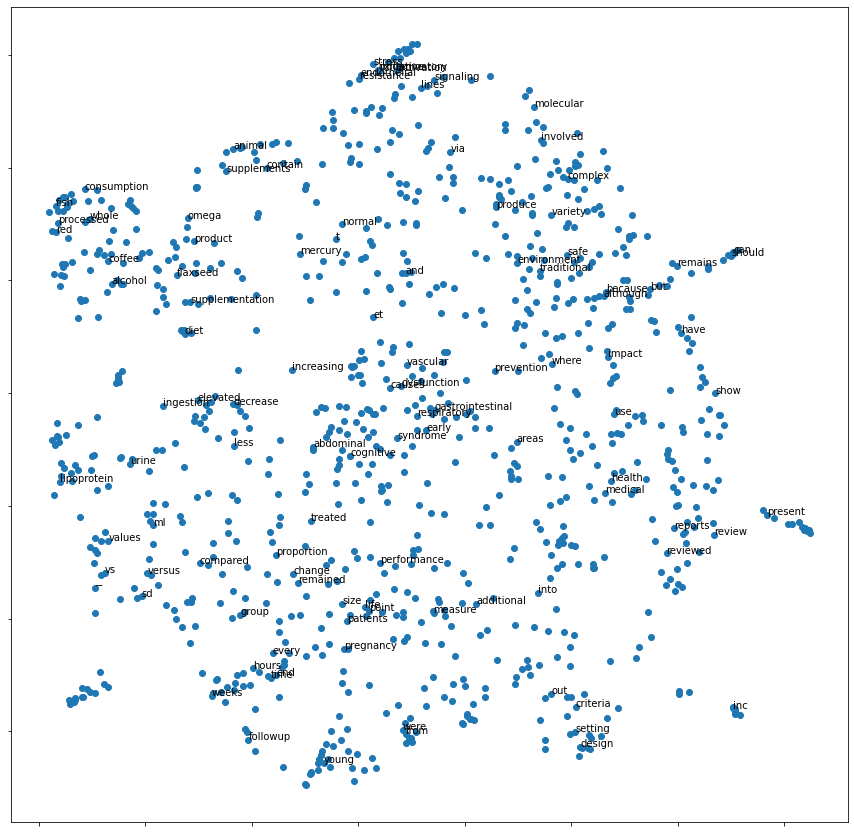

In [31]:
# UMAP
import umap.umap_ as umap #package is umap-learn
reducer = umap.UMAP(random_state=RANDOM_SEED)
reducer.fit(X_subset)
Y_subset_umap = reducer.transform(X_subset)
plot(X_subset, Y_subset_umap, W_subset)

Check if the embeddings make sense. Due to the hardware and runtime limitation, we cannot reach the state-of-the-art performance.